<a href="https://colab.research.google.com/github/MatP-DS/MasterThesis/blob/main/svm_train_test_full_features3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, recall_score,
                           precision_score, confusion_matrix,
                           precision_recall_curve, roc_auc_score, auc, roc_curve)
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd
import time
import psutil
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from google.colab import drive


In [ ]:
# System performance tracker
class SVMPerformanceTracker:
    def __init__(self):
        self.start_time = None
        self.peak_ram = 0
        self.cpu_readings = []

    def start(self):
        self.start_time = time.time()
        self.peak_ram = psutil.virtual_memory().used / (1024**3)  # GB
        self.cpu_readings.append(psutil.cpu_percent())

    def update(self):
        current_ram = psutil.virtual_memory().used / (1024**3)
        if current_ram > self.peak_ram:
            self.peak_ram = current_ram
        self.cpu_readings.append(psutil.cpu_percent())

    def get_stats(self):
        return {
            'training_time': time.time() - self.start_time,
            'peak_ram_gb': self.peak_ram,
            'avg_cpu_usage': np.mean(self.cpu_readings),
            'max_cpu_usage': np.max(self.cpu_readings)
        }

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Initialize tracker
tracker = SVMPerformanceTracker()
tracker.start()

# Load and preprocess data
X = np.load("/content/drive/MyDrive/MasterThesis/02_preprocessed_data/X_flattened_final.npz")["X"]
y = np.load("/content/drive/MyDrive/MasterThesis/02_preprocessed_data/y_labels_final.npz")["y"]

# 1. NaN handling
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
tracker.update()

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, stratify=y, test_size=0.2, random_state=42
)

# 3. Feature selection
selector = SelectKBest(score_func=f_classif, k=50)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
tracker.update()

# 4. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)
tracker.update()

# 5. Train SVM
svm = LinearSVC(
    C=0.1,
    class_weight={0: 1, 1: 10},
    dual=False,
    max_iter=1000,
    random_state=42
)

calibrated_svm = CalibratedClassifierCV(svm, cv=3, method='sigmoid')
calibrated_svm.fit(X_train_scaled, y_train)
tracker.update()

# Get performance stats
perf_stats = tracker.get_stats()

# 6. Predict with threshold optimization
y_prob = calibrated_svm.predict_proba(X_test_scaled)[:, 1]


In [ ]:
# Calculate metrics
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
roc_auc = roc_auc_score(y_test, y_prob)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred = (y_prob >= best_threshold).astype(int)

# Inference speed test
start_inf = time.time()
_ = calibrated_svm.predict_proba(X_test_scaled[:1000])  # Warm-up
inf_time = (time.time() - start_inf) / 1000 * 1000  # ms/sample


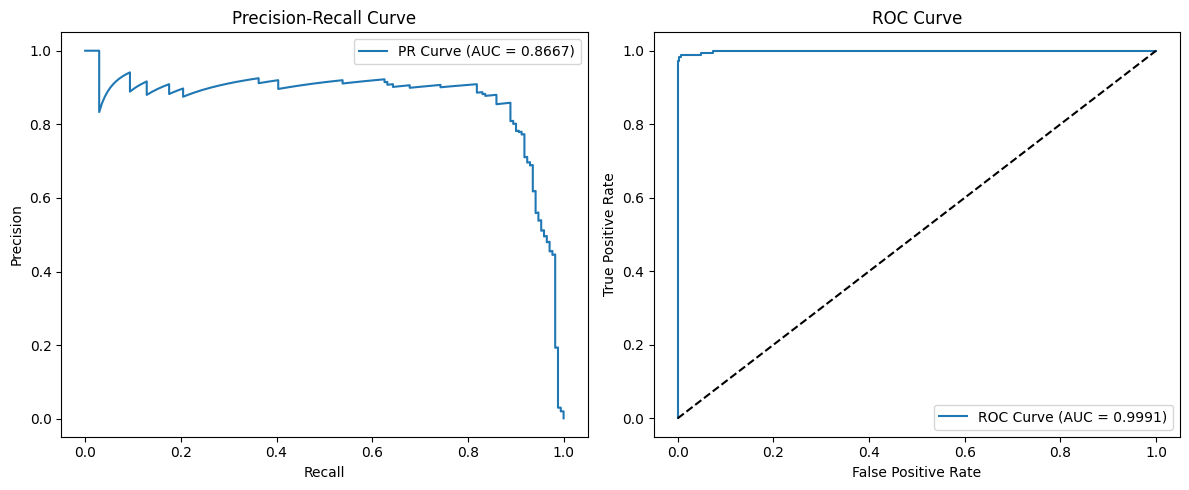


=== SVM Training Complete ===
Training Time: 48.73s
Peak RAM: 4.64GB
CPU Usage: 17.9% (avg), 33.7% (max)

PR-AUC: 0.8667 | ROC-AUC: 0.9991
Inference Speed: 0.0023 ms/sample

Results saved to:
- model: /content/drive/MyDrive/MasterThesis/04_results/metrics/svm_optimized_20250626_031118.joblib
- metrics: /content/drive/MyDrive/MasterThesis/04_results/metrics/svm_metrics_20250626_031118.json
- plots: /content/drive/MyDrive/MasterThesis/04_results/metrics/svm_curves_20250626_031118.png
- confusion_matrix: /content/drive/MyDrive/MasterThesis/04_results/metrics/svm_cm_20250626_031118.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
# Compile metrics
svm_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred, pos_label=1),
    "recall": recall_score(y_test, y_pred, pos_label=1),
    "precision": precision_score(y_test, y_pred, pos_label=1),
    "best_threshold": best_threshold,
    "pr_auc": pr_auc,
    "roc_auc": roc_auc,
    "training_time": perf_stats['training_time'],
    "peak_ram_gb": perf_stats['peak_ram_gb'],
    "avg_cpu_usage": perf_stats['avg_cpu_usage'],
    "max_cpu_usage": perf_stats['max_cpu_usage'],
    "inference_speed": inf_time,
    "num_features": X_train_selected.shape[1]
}

# Confusion matrix
svm_cm = confusion_matrix(y_test, y_pred)
svm_cm_df = pd.DataFrame(
    svm_cm,
    index=["No Loss (0)", "Loss (1)"],
    columns=["Predicted 0", "Predicted 1"]
)

# Plot curves
plt.figure(figsize=(12, 5))

# PR Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Enhanced saving function
def save_svm_results(model, metrics, cm_df, folder="/content/drive/MyDrive/MasterThesis/04_results/metrics"):
    os.makedirs(folder, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save model
    model_path = os.path.join(folder, f"svm_optimized_{timestamp}.joblib")
    from joblib import dump
    dump(model, model_path)

    # Save metrics
    metrics_path = os.path.join(folder, f"svm_metrics_{timestamp}.json")
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=4, default=lambda x: float(x) if isinstance(x, (np.float32, np.float64)) else x)

    # Save plots
    plot_path = os.path.join(folder, f"svm_curves_{timestamp}.png")
    plt.savefig(plot_path)

    # Save confusion matrix
    cm_path = os.path.join(folder, f"svm_cm_{timestamp}.csv")
    cm_df.to_csv(cm_path)

    return {
        "model": model_path,
        "metrics": metrics_path,
        "plots": plot_path,
        "confusion_matrix": cm_path
    }

# Save all results
results = save_svm_results(calibrated_svm, svm_metrics, svm_cm_df)

# Print summary
print("\n=== SVM Training Complete ===")
print(f"Training Time: {svm_metrics['training_time']:.2f}s")
print(f"Peak RAM: {svm_metrics['peak_ram_gb']:.2f}GB")
print(f"CPU Usage: {svm_metrics['avg_cpu_usage']:.1f}% (avg), {svm_metrics['max_cpu_usage']:.1f}% (max)")
print(f"\nPR-AUC: {svm_metrics['pr_auc']:.4f} | ROC-AUC: {svm_metrics['roc_auc']:.4f}")
print(f"Inference Speed: {svm_metrics['inference_speed']:.4f} ms/sample")
print("\nResults saved to:")
for k, v in results.items():
    print(f"- {k}: {v}")